In [31]:
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dense,Flatten,  Input, Dropout

In [33]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d tawsifurrahman/covid19-radiography-database

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
 99% 770M/778M [00:09<00:00, 77.3MB/s]
100% 778M/778M [00:09<00:00, 88.2MB/s]


In [34]:
! unzip covid19-radiography-database.zip -d /content/data

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: /content/data/COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: /content/data/COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: /content/data/COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: /content/data/COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: /content/data/COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: /content/data/COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: /content/data/COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: /content/data/COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: /content/data/COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: /content/data/COVID-19_Radiography_Dataset/Normal/masks/Normal-7930

In [35]:
base = Xception(weights="imagenet", input_shape =(299,299,3),include_top= False)
for layers in base.layers:
    layers.trainable=False

base.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

Found 31748 images belonging to 1 classes.
Found 10582 images belonging to 1 classes.


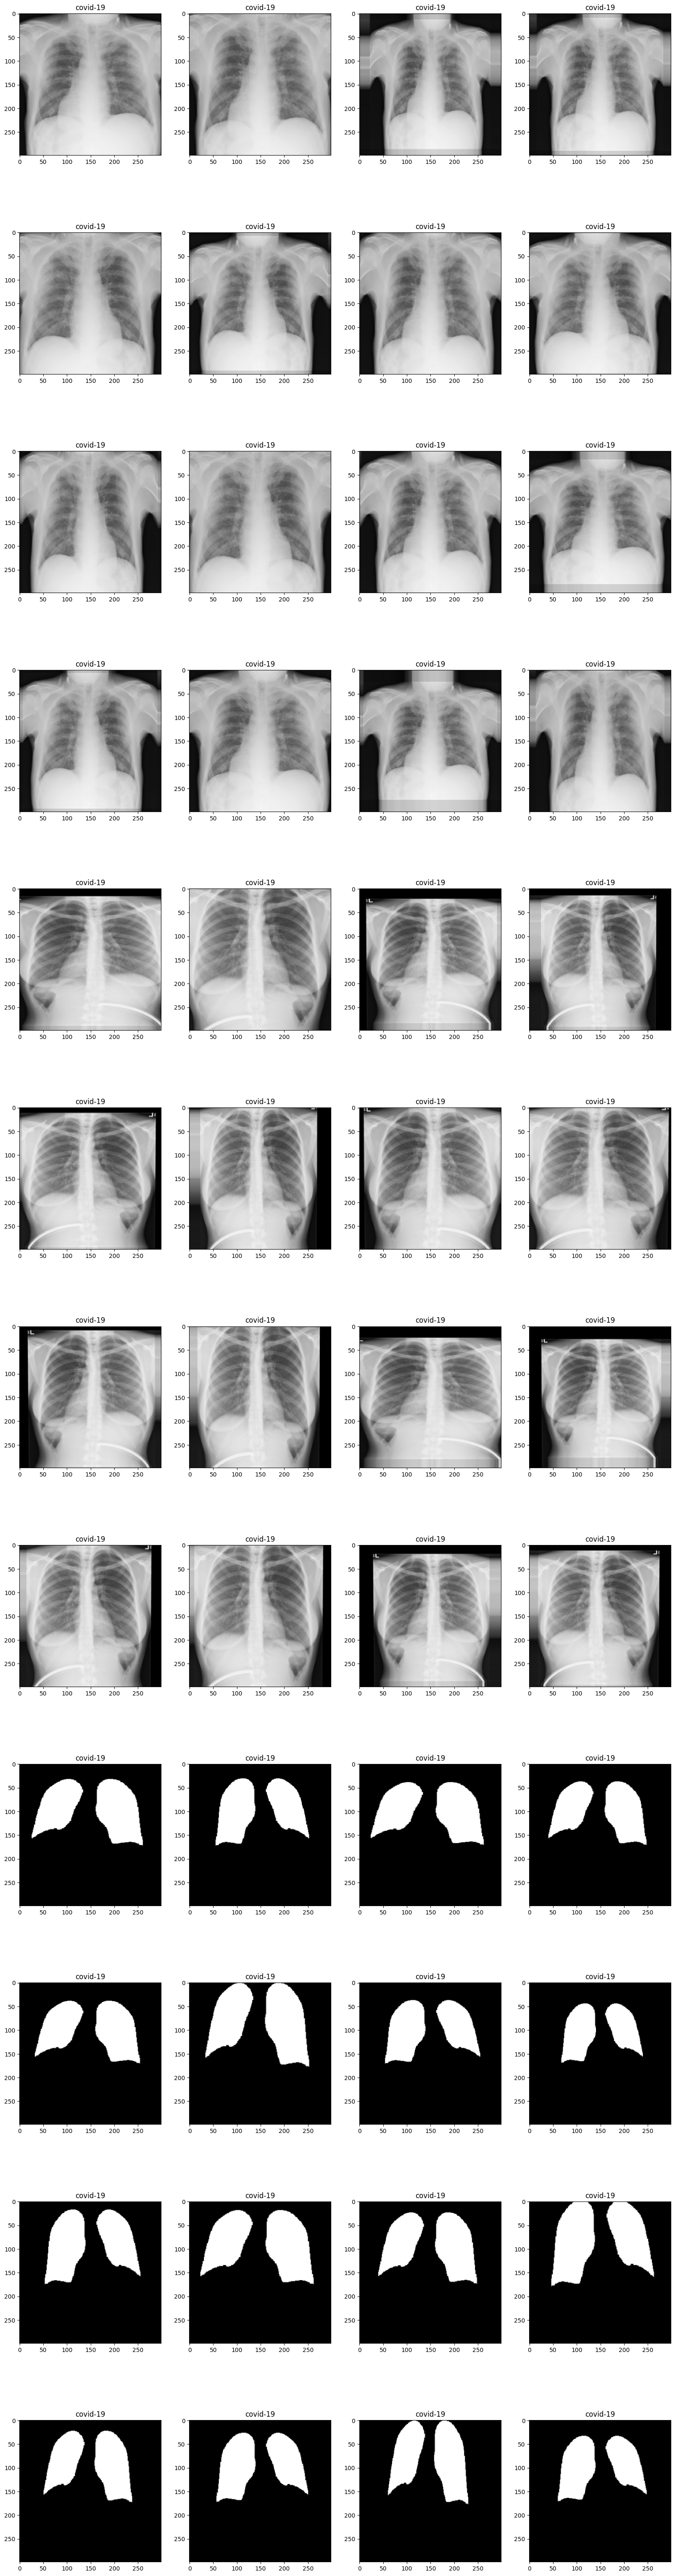

In [36]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        validation_split=0.25,
        horizontal_flip =True
        )
train =train_datagen.flow_from_directory(
    "data/",
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')
val =train_datagen.flow_from_directory(
    "data/",
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')
class_names=['covid-19','normal','pneumonia']
def plotImages(images_arr, labels):
    fig, axes = plt.subplots(12, 4, figsize=(20,80))
    axes = axes.flatten()
    label=0
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.set_title(class_names[np.argmax(labels[label])])
        label=label+1
    plt.show()
images = [train[34][0][0] for i in range(16)]
images = images + [train[5][0][0] for i in range(16)]
images = images + [train[0][0][0] for i in range(16)]
labels=[]
labels = [train[34][1][0] for i in range(16)]
labels=  labels + [train[5][1][0] for i in range(16)]
labels=  labels + [train[0][1][0] for i in range(16)]
plotImages(images,labels)


In [37]:

model = Sequential()
model.add(Input(shape =(299,299,3)))
model.add(base)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(16))
model.add(Dense(3,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 dropout (Dropout)           (None, 10, 10, 2048)      0         
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 dropout_1 (Dropout)         (None, 204800)            0         
                                                                 
 dense (Dense)               (None, 16)                3276816   
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                                 
Total params: 24,138,347
Trainable params: 3,276,867
Non

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit_generator(train,epochs=30,validation_data=val)
model.save('epoch_30.h5')

<ipython-input-38-b3152e56949e>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train,epochs=30,validation_data=val)


Epoch 1/30
 19/635 [..............................] - ETA: 4:11:27 - loss: 79.4287 - accuracy: 0.0074